## **Loading required Libraries**

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!wget https://github.com/snikhil17/Road_Safety/raw/main/Data/Tweets%2041k.zip

--2022-02-08 11:35:55--  https://github.com/snikhil17/Road_Safety/raw/main/Data/Tweets%2041k.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/snikhil17/Road_Safety/main/Data/Tweets%2041k.zip [following]
--2022-02-08 11:35:55--  https://raw.githubusercontent.com/snikhil17/Road_Safety/main/Data/Tweets%2041k.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6923891 (6.6M) [application/zip]
Saving to: ‘Tweets 41k.zip.1’

Tweets 41k.zip.1    100%[===================>]   6.60M  --.-KB/s    in 0.08s   

2022-02-08 11:35:55 (82.7 MB/s) - ‘Tweets 41k.zip.1’ saved [6923891/6923891]



In [23]:
!unzip "Tweets 41k.zip"

Archive:  Tweets 41k.zip
replace Tweets 41k/road_accidents_india_40k_0_200.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [24]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import re
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer


nltk.download('words')

from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
nlp = spacy.load('en_core_web_sm')


from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import gensim
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
import glob
import os
import pandas as pd
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('/content/Tweets 41k/', "road_accidents_india_40k_*.csv"))), ignore_index= True).drop('Unnamed: 0', axis = 1)
df.head()

,tweet_content,labels_zero_shot,respective_scores,best_labels_scores,best_labels,sentiments_one_shot_classifier_score,sentiments_one_shot_classifier,cleaned_text,sentiment_via_VADER
0,The Dera followers across India have taken the...,"['positive information', 'negative information...","[0.6932814717292786, 0.13189217448234558, 0.09...","{'positive information': 0.6932814717292786, '...","['positive information', 'negative information']",{'positive': 0.8888261914253235},positive,follower take initiative prevent road accident...,negative
1,Saint Dr. @Gurmeetramrahim ji🌸\n#RoadSafetyIni...,"['positive information', 'negative information...","[0.6274787783622742, 0.15558470785617828, 0.14...","{'positive information': 0.6274787783622742, '...","['positive information', 'negative information']",{'positive': 0.6677867770195007},positive,follower take initiative prevent road accident...,negative
2,The Dera followers across India have taken the...,"['positive information', 'negative information...","[0.6528342366218567, 0.16880010068416595, 0.11...","{'positive information': 0.6528342366218567, '...","['positive information', 'negative information']",{'positive': 0.844313383102417},positive,follower take initiative prevent road accident...,negative
3,#RoadSafetyInitiativeByDSS\nThe Dera followers...,"['positive information', 'appreciation', 'nega...","[0.7812352180480957, 0.07765661180019379, 0.07...","{'positive information': 0.7812352180480957, '...","['positive information', 'appreciation']",{'positive': 0.8634591698646545},positive,dera follower take initiative prevent road acc...,negative
4,The Dera followers across India have taken the...,"['positive information', 'appreciation', 'nega...","[0.6620956063270569, 0.14676465094089508, 0.11...","{'positive information': 0.6620956063270569, '...","['positive information', 'appreciation']",{'positive': 0.8870344161987305},positive,follower take initiative prevent road accident...,negative


In [114]:
import ast
final_score_list = []
for i in range(df.shape[0]):
  final_score_list.append(list(ast.literal_eval(df.sentiments_one_shot_classifier_score.iloc[i]).values())[0])

df['sentiment_score'] = final_score_list

In [118]:
df.sentiments_one_shot_classifier.value_counts()

negative    34071
positive     6465
Name: sentiments_one_shot_classifier, dtype: int64

In [131]:

df_negative = df[(df['sentiments_one_shot_classifier'] == 'negative') & (df.sentiment_score > 0.978)]
df_positive = df[(df['sentiments_one_shot_classifier'] == 'positive')]
df_negative.shape, df_positive.shape

((9612, 11), (6465, 11))

In [133]:
df  = pd.concat([df_negative, df_positive], ignore_index=True, sort=False)
# final_df = final_df[final_df.tweet_content.map(lambda x: x.isascii())] #removing non-english rows
df.sentiments_one_shot_classifier.value_counts(normalize = True)

negative    0.597873
positive    0.402127
Name: sentiments_one_shot_classifier, dtype: float64

## **Cleaning Helper Functions** 
- **Function for decontracted and removing IP adresses and other expressions using Regex**
  - words like don't , won't etc will be converted to do not, will not etc.
  - Emojis, additional lines, email-addresses, website names etc are removed here.
- **Removed words like ``no, not, nor`` from english stopwords**
- **Removing Non-English Words**
  - whatever words nltk corpus has, if given word is in that corpus we will consider the word, else replace with blank.
- **Removing Contextual Stopwords**
  - Using POS-tagging feature of Spacy, removed words which were Pronoun, punctuation, number, adverb  etc.
  - Lemmatizing th words and checking if the given word exist in the list of words needs to be removed (contextual words: obtained after checking the word counts)
- **Remaining Preprocessing of text**
  - Combining all the above functions to use as analyzer in TF-IDF vectorizer. 

In [64]:
import re
import unicodedata

stop_words=stopwords.words('english') + ['&amp','&amp;']



"""Functions to clean text using Regex"""
ip_addr_regex = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def regex_cleaning(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"[^a-zA-Z0-9]+", " ", phrase)
    phrase = re.sub('[\(\[].*?[\)\]]', ' ', phrase)
    phrase = unicodedata.normalize('NFKD', phrase).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    phrase = re.sub(r"\r\n", "", phrase)            # Removing additional line
    phrase = re.sub(r"\n", "", phrase)              # Removing additional line 
    phrase = re.sub(r"\S*@\S*\s?", "", phrase)      # Removing email-addresses 
    phrase = re.sub(r'http\S+', '', phrase)         # Removing website links
    phrase = re.sub(ip_addr_regex, "", phrase)      # Removing IP address link.
    phrase = emoji_pattern.sub(r'', phrase)         # Removing Emojis
    
    # phrase_final = " ".join([word.lower() for word in phrase.split() if word not in stop_words and len(word) > 3])
    phrase_final = [word.lower() for word in phrase.split() if word not in stop_words and len(word) > 3]
    return "" if len(phrase_final) < 3 else " ".join(phrase_final)  


In [134]:
df.columns

Index(['tweet_content', 'labels_zero_shot', 'respective_scores',
       'best_labels_scores', 'best_labels',
       'sentiments_one_shot_classifier_score',
       'sentiments_one_shot_classifier', 'cleaned_text', 'sentiment_via_VADER',
       'clean_corpus', 'sentiment_score'],
      dtype='object')

In [135]:
df.sentiments_one_shot_classifier.value_counts(normalize =True)

negative    0.597873
positive    0.402127
Name: sentiments_one_shot_classifier, dtype: float64

In [136]:
df.sentiment_via_VADER.value_counts(normalize =True)

negative    0.939791
positive    0.060209
Name: sentiment_via_VADER, dtype: float64

In [137]:
df.tweet_content.iloc[55]

'In 2018, India had fewer road accidents but more fatal ones https://t.co/wrO8mnGnNH via @timesofindia'

In [138]:
df[(df.sentiment_via_VADER == 'positive') & (df.sentiments_one_shot_classifier == 'negative')][['tweet_content']]

,tweet_content
34,India: Union Transport Minister said his plans...
107,@ShraddhaKapoor We respect women but \n\nNo ge...
209,#JacobMartin played 10 ODIs for India from 199...
361,"@ippatel Police is doing their duty , he follo..."
392,Are people roaming around without wearing mask...
1206,@ArleneFosterUK All of us here at the UKs only...
1212,"Namaste @PMOIndia @narendramodi ji, We shouldn..."
1390,"#wineshops after all the peaceful times, there..."
1543,Joke is on the people who learned nothing from...
1649,@DikshitSmita Partly agree but this act gives ...


In [139]:
df.sentiments_one_shot_classifier.value_counts()

negative    9612
positive    6465
Name: sentiments_one_shot_classifier, dtype: int64

## **Using Helper functions to clean the data**

In [140]:
"""Functions to clean text using Regex"""
ip_addr_regex = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def regex_cleaning(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"[^a-zA-Z0-9]+", " ", phrase)
    phrase = re.sub('[\(\[].*?[\)\]]', ' ', phrase)
    phrase = unicodedata.normalize('NFKD', phrase).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    phrase = re.sub(r"\r\n", "", phrase)            # Removing additional line
    phrase = re.sub(r"\n", "", phrase)              # Removing additional line 
    phrase = re.sub(r"\S*@\S*\s?", "", phrase)      # Removing email-addresses 
    phrase = re.sub(r'http\S+', '', phrase)         # Removing website links
    phrase = re.sub(ip_addr_regex, "", phrase)      # Removing IP address link.
    phrase = emoji_pattern.sub(r'', phrase)         # Removing Emojis
    
    # phrase_final = " ".join([word.lower() for word in phrase.split() if word not in stop_words and len(word) > 3])
    phrase_final = [word.lower() for word in phrase.split() if word not in stop_words and len(word) > 3]
    return "" if len(phrase_final) < 3 else " ".join(phrase_final)  

def word_2_vec_train(df_corpus):
  story = []
  clean_corpus = df_corpus.apply(regex_cleaning)
  for doc in clean_corpus:
      raw_sent = sent_tokenize(doc)
      for sent in raw_sent:
          story.append(simple_preprocess(sent))
  model_gensim = gensim.models.Word2Vec( 
      window=10,
      min_count=2
  )
  model_gensim.build_vocab(story)
  model_gensim.train(story, total_examples=model_gensim.corpus_count, epochs=model_gensim.epochs)

  # remove out-of-vocabulary words
  doc = [word for word in doc.split() if word in model_gensim.wv.index2word]
  return model_gensim, np.mean(model_gensim.wv[doc], axis=0)

def word_2_vec_transform(doc, model_gensim):
  clean_doc = regex_cleaning(doc)
  doc = [word for word in doc.split() if word in model_gensim.wv.index2word]
  return np.mean(model_gensim.wv[doc], axis=0)

In [141]:
# df = df[df.tweet_content.map(lambda x: x.isascii())]
df['clean_corpus'] = df['tweet_content'].apply(regex_cleaning)
df = df[~(df['clean_corpus'] == '')] # Selecting rows which doesnt have empty values

In [142]:
# model_gensim, vec = word_2_vec_train(df.tweet_content)
# remove out-of-vocabulary word
story = []
for doc in df['tweet_content']:
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        story.append(simple_preprocess(sent))

# Word2Vec model
model_gensim = gensim.models.Word2Vec( 
    window=10,
    min_count=2
)

model_gensim.build_vocab(story) #building vocabulary

model_gensim.train(story, total_examples=model_gensim.corpus_count, epochs=model_gensim.epochs) # training the model
def document_vector(doc):
    doc = [word for word in doc.split() if word in model_gensim.wv.index2word]
    return np.mean(model_gensim.wv[doc], axis=0)

In [143]:
"""In case some rows still have non-english words: e.g. words left from hashtags"""
# remove_rows = [5244, 30227, 30753]
# for rows in remove_rows:
df.drop(df.iloc[30753].name, inplace = True)

IndexError: ignored

In [147]:
"""Applying Word2Vec on whole data"""
from tqdm import tqdm
X = []
for doc in tqdm(df['tweet_content'].values):
  clean_doc = regex_cleaning(doc)
  X.append(document_vector(clean_doc))

100%|██████████| 16077/16077 [00:25<00:00, 642.24it/s]


In [148]:
"""Converting the list to array"""
X = np.array(X)
X[0]

array([ 1.2392414 , -0.5461317 ,  0.22603843,  0.58619994, -0.2821199 ,
        0.35476762, -0.18892801, -0.8905152 , -0.05485167,  0.15159881,
        0.43575487, -0.18481593, -0.7841195 , -0.14616133, -0.35766578,
       -0.6715085 ,  0.7725897 ,  0.11418958, -0.04181656, -1.2434547 ,
       -0.01374784, -0.51570374, -0.4465645 , -0.57193935, -0.7199698 ,
       -0.84556496, -0.45986718,  0.66710263, -0.3420115 ,  0.4001822 ,
        0.69861287,  0.46147758,  0.11368301, -0.45561638, -0.13727236,
       -0.5136942 , -0.6760129 , -0.12404883, -0.06626768, -0.18655436,
        1.0986191 , -0.36025527, -0.03840779, -0.03658637,  0.03756427,
        1.0091736 , -0.19789185,  0.16139212,  0.27346435, -0.84654456,
        0.12732565,  0.291108  ,  0.7331064 , -0.179261  , -0.01003943,
        0.36774424,  0.65924627,  0.57795376,  0.14303502, -0.17117925,
       -0.41966805, -0.4407126 ,  0.17024048, -0.33329216, -0.5948881 ,
        0.0081243 , -0.03777701,  1.3520876 , -0.25472227,  0.17

In [149]:
"""Decalring Features and Label"""
features = X.copy()
labels = df['sentiments_one_shot_classifier'].values

In [150]:
# # Splitting the data into Training and Testing set
X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify = labels,   test_size= 0.3,  random_state = 42)

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [152]:
svc = SVC( kernel="linear", class_weight='balanced' )
knc = KNeighborsClassifier()
# mnb = MultinomialNB()
dtc = DecisionTreeClassifier()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier( random_state=7)
abc = AdaBoostClassifier( random_state=7)
bc = BaggingClassifier(random_state=7)
etc = ExtraTreesClassifier(random_state=7)
gbdt = GradientBoostingClassifier(random_state=7)
xgb = XGBClassifier(random_state=7)

In [153]:
clfs = {'SVC':svc,
    'KN' : knc, 
    # 'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [154]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    accuracy_train = metrics.accuracy_score(y_train,train_pred )
    accuracy_test = metrics.accuracy_score(y_test,test_pred)
    precision_train = metrics.precision_score(y_train,train_pred, average="macro")
    precision_test = metrics.precision_score(y_test,test_pred, average="macro")
    recall_train = metrics.recall_score(y_train,train_pred, average="macro")
    recall_test = metrics.recall_score(y_test,test_pred, average="macro")
    
    return accuracy_train,accuracy_test, precision_train, precision_test, recall_train, recall_test

In [155]:
import warnings
warnings.filterwarnings('ignore')


accuracy_scores_tr = []
accuracy_scores_ts = []
precision_tr_scores = []
precision_ts_scores = []
recall_tr_scores = []
recall_ts_scores = []

for name,clf in clfs.items():
    
    current_accuracy_tr,current_accuracy_ts,precision_tr, precision_ts, recall_tr, recall_ts = train_classifier(clf, X_train,
                                                                                                      y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy Train - ",current_accuracy_tr)
    print("Accuracy Test - ",current_accuracy_ts)
    print("Precision Train - \n",precision_tr)
    print("Precision Test - \n",precision_ts)
    print("Recall Train - \n",recall_tr)
    print("Recall Test - \n",recall_ts)
    
    accuracy_scores_tr.append(current_accuracy_tr)
    accuracy_scores_ts.append(current_accuracy_ts)
    precision_tr_scores.append(precision_tr)
    precision_ts_scores.append(precision_ts)
    recall_tr_scores.append(recall_tr)
    recall_ts_scores.append(recall_ts)
    print()
    print("="*100)
    print()

For  SVC
Accuracy Train -  0.7912556651559585
Accuracy Test -  0.789179104477612
Precision Train - 
 0.7841156303568646
Precision Test - 
 0.7822901796190215
Recall Train - 
 0.7784681647078918
Recall Test - 
 0.7754275276320117


For  KN
Accuracy Train -  0.8630587398915844
Accuracy Test -  0.796849087893864
Precision Train - 
 0.8635860720520092
Precision Test - 
 0.7944052063210949
Recall Train - 
 0.8495870970496844
Recall Test - 
 0.777624147446988


For  DT
Accuracy Train -  0.9995556740424776
Accuracy Test -  0.7719734660033167
Precision Train - 
 0.9995560409376574
Precision Test - 
 0.7628858024691358
Recall Train - 
 0.9995198757070312
Recall Test - 
 0.7630624705091725


For  LR
Accuracy Train -  0.7932995645605616
Accuracy Test -  0.7906301824212272
Precision Train - 
 0.7936106982861312
Precision Test - 
 0.7912832871317668
Recall Train - 
 0.7707342120995132
Recall Test - 
 0.7673613394912564


For  RF
Accuracy Train -  0.9995556740424776
Accuracy Test -  0.83768656716417

In [157]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy Train':accuracy_scores_tr,'Accuracy Test':accuracy_scores_ts,
                               'Precision Train':precision_tr_scores,'Precision Test':precision_ts_scores,
                               'Recall Train':recall_tr_scores,'Recall Test':recall_ts_scores}).style.background_gradient(cmap = 'magma_r', subset = ['Recall Test', 'Precision Test', 'Accuracy Test'	])
performance_df

,Algorithm,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,SVC,0.791256,0.789179,0.784116,0.782290,0.778468,0.775428
1,KN,0.863059,0.796849,0.863586,0.794405,0.849587,0.777624
2,DT,0.999556,0.771973,0.999556,0.762886,0.999520,0.763062
3,LR,0.793300,0.790630,0.793611,0.791283,0.770734,0.767361
4,RF,0.999556,0.837687,0.999556,0.841732,0.999520,0.818274
5,AdaBoost,0.787346,0.780473,0.783143,0.775754,0.768722,0.761397
6,BgC,0.988536,0.811360,0.989998,0.812778,0.986252,0.790519
7,ETC,0.999556,0.833333,0.999556,0.839408,0.999520,0.811934
8,GBDT,0.837999,0.804726,0.846531,0.809375,0.815605,0.780416
9,xgb,0.831778,0.807629,0.841393,0.813938,0.807942,0.782590


In [161]:
%%time
# from sklearn.ensemble import RandomForestClassifier
lr = SVC(C = 0.001 , kernel="linear", class_weight='balanced')
lr.fit(X_train,y_train)

preds_train = lr.predict(X_train)                                            # Prediction on training set
preds_test = lr.predict(X_test)                                              # Prediction on training set

training_metrics = metrics.classification_report(y_train, preds_train)                    # Getting Classification report of Training set predictions
testing_metrics = metrics.classification_report(y_test, preds_test)                       # Getting Classification report of Test set predictions

print(f"Training Confusion Matrix: \n{metrics.confusion_matrix(y_train, preds_train)}\n") # Printing Confusion Matrix (training)
print(f"Training Classification Report: \n{training_metrics}")                            # Printing Classification report (testing)
print("="*100)
print(f"Testing Confusion Matrix: \n{metrics.confusion_matrix(y_test, preds_test)}\n")    # Printing Confusion Matrix (training)
print(f"Testing Classification Report: \n{testing_metrics}")                              # Printing Classification report (testing)

Training Confusion Matrix: 
[[4373 2355]
 [1137 3388]]

Training Classification Report: 
              precision    recall  f1-score   support

    negative       0.79      0.65      0.71      6728
    positive       0.59      0.75      0.66      4525

    accuracy                           0.69     11253
   macro avg       0.69      0.70      0.69     11253
weighted avg       0.71      0.69      0.69     11253

Testing Confusion Matrix: 
[[1893  991]
 [ 503 1437]]

Testing Classification Report: 
              precision    recall  f1-score   support

    negative       0.79      0.66      0.72      2884
    positive       0.59      0.74      0.66      1940

    accuracy                           0.69      4824
   macro avg       0.69      0.70      0.69      4824
weighted avg       0.71      0.69      0.69      4824

CPU times: user 18.3 s, sys: 58 ms, total: 18.4 s
Wall time: 19.1 s


<Figure size 1080x1080 with 0 Axes>

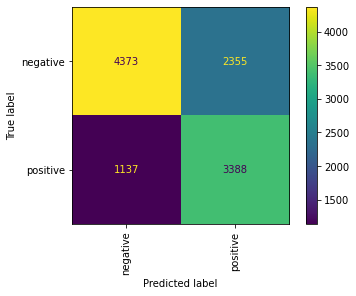

In [162]:
plt.figure(figsize = (15,15))
metrics.plot_confusion_matrix(lr,X_train,y_train, )  
plt.xticks(rotation = 90)
plt.show()


In [164]:
suff_  = round(metrics.f1_score(y_test, preds_test,average = 'weighted' ), 3)
import pickle
"""Save the Bagging CLF model"""
output_file = f'model_sentiment_analysis_SVC_{suff_}.pkl'

with open(output_file, 'wb') as f_out:
    pickle.dump(lr, f_out)

In [165]:
output_file = f'model_gensim_sentiment.pkl'

with open(output_file, 'wb') as f_out:
    pickle.dump(model_gensim, f_out)